## **View MitoNet segmentations in 3D**
---
Visualize results from MitoNet segmentation

In [2]:
# Data import
import webknossos as wk
import numpy as np

# Napari
import napari
from empanada_napari._volume_inference import volume_inference_widget
import empanada

# Analysis
import matplotlib.pyplot as plt
import pandas as pd

In [32]:
# Create an empty viewer
viewer = napari.Viewer()

In [33]:
def import_wk_dataset_seg_local(dir_path, segmentation, MAG_seg, MAG_EM, layer="color", bbox_EM=None, bbox_seg=None) -> None:
    # open local dataset in given directory 
    dataset = wk.Dataset.open(
        dataset_path = dir_path)
    voxel_size = dataset.voxel_size

    EM = dataset.get_layer(layer) # Layer
    labels = dataset.get_layer(segmentation) # Segmentation Layer
    mag_view = EM.get_mag(MAG_EM) # MagView
    mag_view_seg = labels.get_mag(MAG_seg) # MagView

    view = mag_view.get_view(absolute_offset=bbox_EM.topleft, size=bbox_EM.size) # "absolute_offset" and "size" are in Mag(1)!
    view_seg = mag_view_seg.get_view(absolute_offset=bbox_seg.topleft, size=bbox_seg.size) # "absolute_offset" and "size" are in Mag(1)!
    
    data = view.read()
    seg = view_seg.read()

    # return data, voxel size
    return dataset, data, seg, voxel_size

### **3.1 Configure dataset parameters**
---

In [34]:
TOKEN = "A_KRh0eDGiIuQMTL1EKxWg" # Don't share with others!
url = "https://webknossos.tnw.tudelft.nl"
dataset_name = "20230626_RP_serial"
organization_id = "hoogenboom-group"
dir_path = 'Z:/webknossos/binaryData/hoogenboom-group/20230626_RP_serial'
mag_x_seg, mag_y_seg, mag_z_seg = 4, 4, 1 # For MitoNet predictions 4, 4, 1 or larger, no 2, 2, 1 and 1, 1, 1 exist!
mag_x_EM, mag_y_EM, mag_z_EM = 2, 2, 1
MAG_seg = wk.Mag(f"{mag_x_seg}-{mag_y_seg}-{mag_z_seg}")
MAG_EM = wk.Mag(f"{mag_x_EM}-{mag_y_EM}-{mag_z_EM}")

In [35]:
# Define bboxes separately because they can be on different zoom levels
bbox_EM = wk.BoundingBox((14931, 14087, 0),
                         (4096, 4096, 43)).align_with_mag(MAG_EM) # ((x0, y0, z0), (x_size, y_size, z_size))
bbox_seg = wk.BoundingBox((14931, 14087, 0),
                          (4096, 4096, 43)).align_with_mag(MAG_seg) # ((x0, y0, z0), (x_size, y_size, z_size))

### **3.2 Read data from WebKnossos (remote or local)**
---
Reads data and segmentations test stack from local `WebKnossos` dataset

In [36]:
# For local access
dataset, data, seg, voxelsize = import_wk_dataset_seg_local(dir_path,
                                                            segmentation="mito-segmentation-full4",
                                                            MAG_seg=MAG_seg,
                                                            MAG_EM=MAG_EM,
                                                            bbox_EM=bbox_EM,
                                                            bbox_seg=bbox_seg) 
scale_factor = voxelsize[2] / voxelsize[0] / (mag_x / mag_z) # determine scalefactor for viewing
data, seg = np.squeeze(data), np.squeeze(seg)
data.shape # Coordinates are (x, y, z), but Napari weirdly reads this as (y, z, x)...
data.shape # Coordinates are (x, y, z), but Napari weirdly reads this as (z, x, y)...

c:\Users\ajkievits\Miniconda3\envs\mito-seg\lib\site-packages\webknossos\dataset\view.py:640: UserWarning: [WARNING] get_view() was called without block alignment. Please only use sequentially, parallel access across such views is error-prone.
  warnings.warn(


(2047, 2047, 43)

### **3.2 Add data + segmentations to `Napari` viewer**
---
Reads data and segmentations from WebKnossos into `Napari`

In [40]:
# Add data tp viewer
viewer.add_image(np.transpose(data, (2, 0, 1)),
                              scale=(scale_factor, 1, 1)) # Use scalefactor for realistic rendering

# Add segmentation
labels_layer = viewer.add_labels(np.transpose(seg, (2, 0, 1)), 
                                 name='segmentation', 
                                 scale=(scale_factor, mag_x_seg/mag_x_EM, mag_x_seg/mag_x_EM)) # Scale to EM  

### 3.3 **Some quick statistics**
---
Compute some statistics with `numpy`

In [9]:
# This is for the 3D inference (3D instance segmentation)
label_layer = viewer.layers['mito-segmentation']
mito_labels = np.squeeze(label_layer.data)
volumes = np.transpose(np.unique(mito_labels, 
                    return_counts=True))
mito_volumes = pd.DataFrame(data=volumes[1:], columns=['label','volume (voxels)']) # Ignore background label which is 0
mito_volumes.head()

KeyError: "'mito-segmentation' is not in list"

<Axes: >

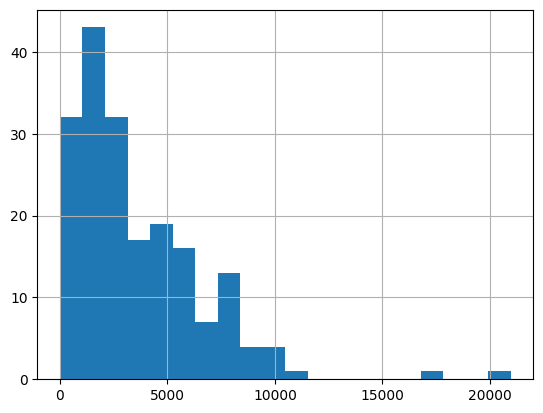

In [24]:
# Plot histogram of volumes
mito_volumes['volume (voxels)'].hist(bins=20)

### **3.4 Save data + segmentations to disk**
---
Saves `Napari` data and segmentation layers to disk

In [10]:
## Segmentation
viewer.layers['segmentation'].save('seg_RP.tiff')

['seg_RP.tiff']

In [11]:
## Data
viewer.layers['Image'].save('cells_RP.tiff')

['cells_RP.tiff']